## Signal Processing ENU
August 4, Intern: Diego Varela, Mentor: Surendra Adhikari

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import os
import pandas as pd

In [63]:
data_folder = '/Users/dlugardo/Desktop/data/ENU_v2' # path to the folder with the data 
locations = ['AASI', 'ASKY', 'AVAN', 'BLAS', 'DANE', 'DGJG', 'SRMP'] # Name of some locations

def get_data(location):
    file_name = str(location) + '.ENU.txt'
    path = os.path.join(data_folder, file_name)

    if os.path.isfile(path):
        data = np.loadtxt(path, skiprows=2)
    else:
        file_name = str(location) + '_ENU.txt'
        path = os.path.join(data_folder, file_name)

        if os.path.isfile(path):
            data = np.loadtxt(path, skiprows=2)
        else:
            raise FileNotFoundError(f"Neither '{location}.ENU.txt' nor '{location}_ENU.txt' found in {data_folder}")
    return data

Data file has shape (features, variables). This is how they look like:
 
 | Time (years) | East (mm) | North (mm) | Up (mm) | East_error (mm) | North_error (mm) | Up_error (mm) |
 | ------------ | --------- | ---------- | ------- | --------------- | ---------------- | --------------|
 | 2005.746739  |  81.1990  | -44.5710   | -22.8590|   0.7640        | 1.0650  |  3.8750 |
 | entry 2 ... |   entry 2 ... |entry 2 ... |entry 2 ... |entry 2 ... |entry 2 ... |entry 2 ... |entry 2 ... |


In [65]:
AASI = get_data('SRMP')
AASI_time = AASI[:,0]
AASI_data = AASI[:,1:4]
AASI_error = AASI[:,4:]

AASI_data_detrended = scipy.signal.detrend(AASI_data, axis = 0)

What I am doing with the data:
1. Plots of the Raw Data
2. Detrended data using scipy:  Average is set to zero. 
3. Fast Fourier Transformations: Through frequency, we can observe how often does the signal repeat (i.e. how long are seasons), 
4. PCA: Understand the main drivers of the signal change.

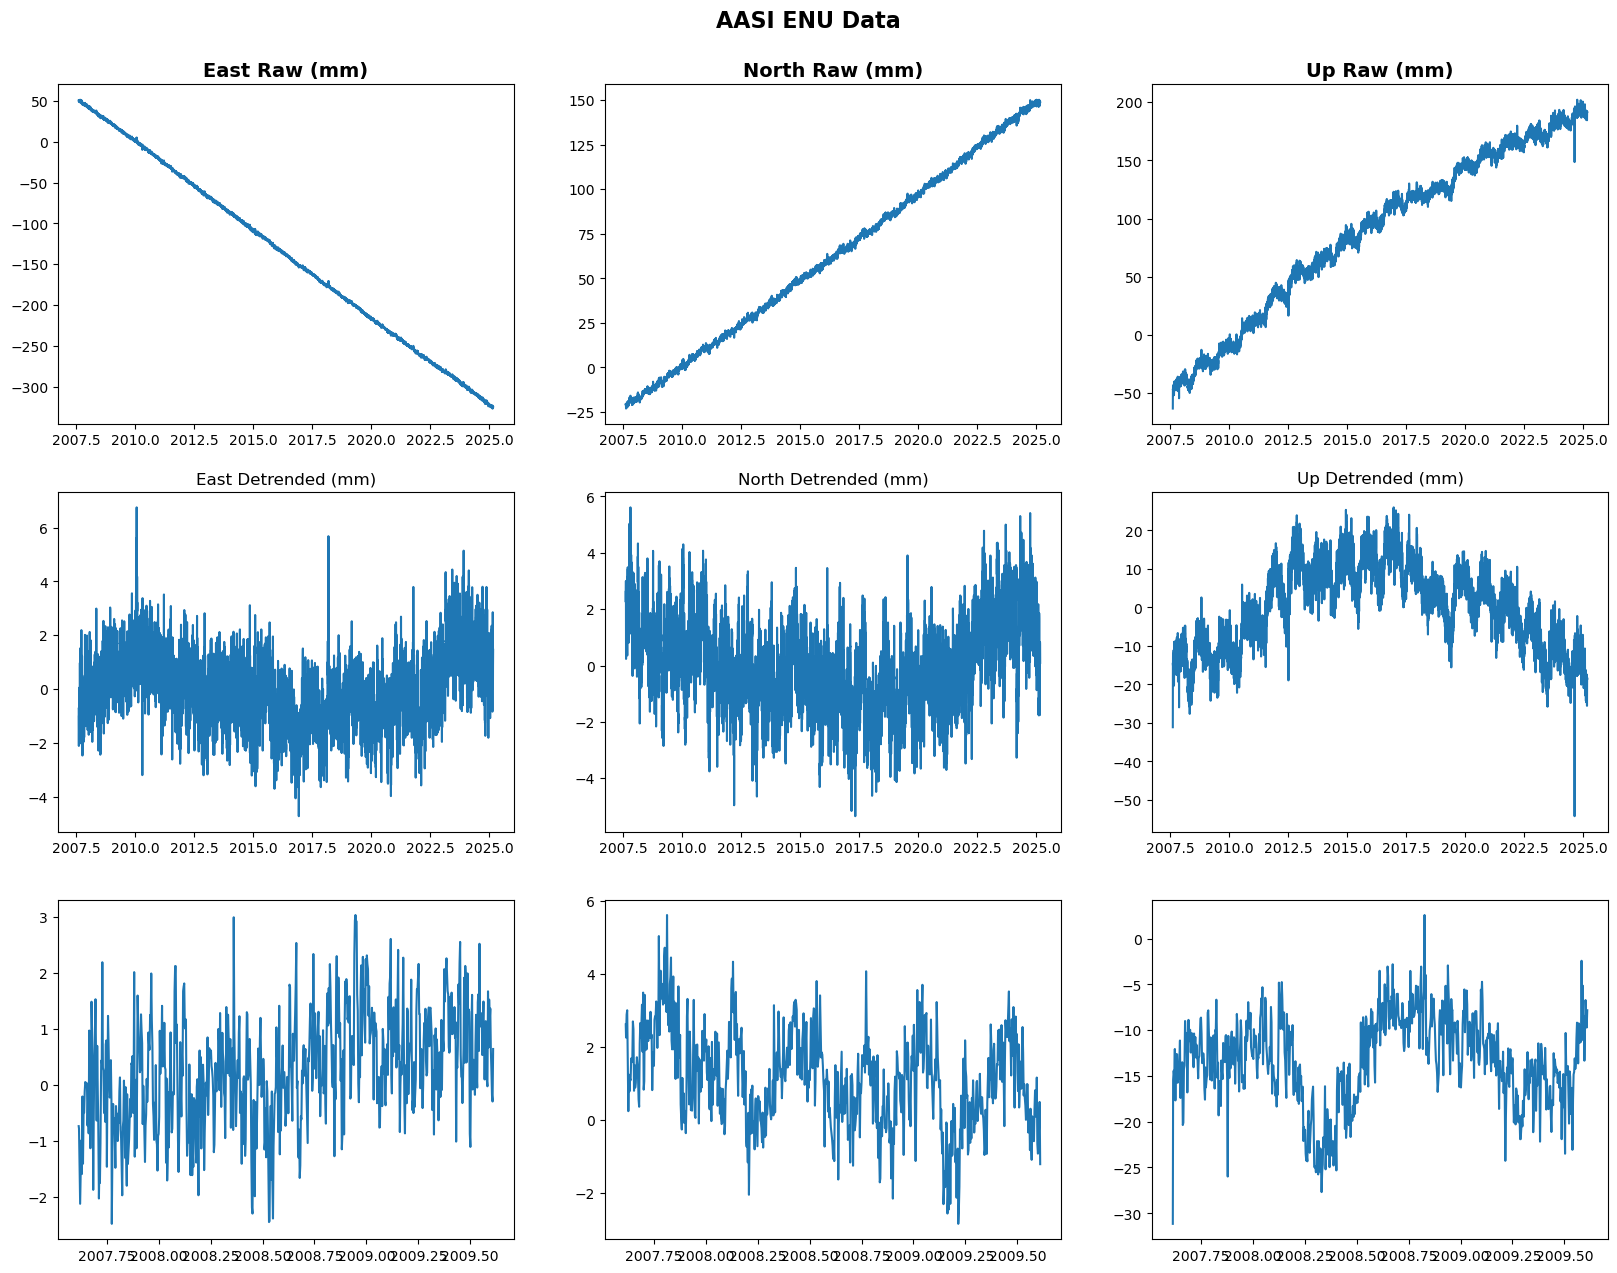

In [66]:
years = 2 
fig, axs = plt.subplots(3, 3, figsize=(20, 15))
titles = ['East (mm)', 'North (mm)', 'Up (mm)']

axs[0,0].plot(AASI_time, AASI_data[:,0])
axs[0,1].plot(AASI_time, AASI_data[:,1])
axs[0,2].plot(AASI_time, AASI_data[:,2])

axs[1,0].plot(AASI_time, AASI_data_detrended[:,0])
axs[1,1].plot(AASI_time, AASI_data_detrended[:,1])
axs[1,2].plot(AASI_time, AASI_data_detrended[:,2])

axs[2,0].plot(AASI_time[:365*years], AASI_data_detrended[:365*years,0])
axs[2,1].plot(AASI_time[:365*years], AASI_data_detrended[:365*years,1])
axs[2,2].plot(AASI_time[:365*years], AASI_data_detrended[:365*years,2])

axs[0,0].set_title('East Raw (mm)', weight = 'bold', size = 14)
axs[0,1].set_title('North Raw (mm)', weight = 'bold', size = 14)
axs[0,2].set_title('Up Raw (mm)', weight = 'bold', size = 14)

axs[1,0].set_title('East Detrended (mm)', size = 12)
axs[1,1].set_title('North Detrended (mm)', size = 12)
axs[1,2].set_title('Up Detrended (mm)', size = 12)

fig.suptitle('AASI ENU Data', weight= 'bold', size = 16, y = 0.93)
plt.show()

In [67]:
def moving_average(a, n=30):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

moving_avg_east = moving_average(AASI_data[:,0])
moving_avg_north = moving_average(AASI_data[:,1])
moving_avg_up = moving_average(AASI_data[:,2])

In [68]:
AASI_error[:,0] + AASI_data[:,0]

array([  52.546,   51.076,   50.383, ..., -325.194, -324.922, -324.763])

Text(0.5, 0.95, 'SRMP Evolution')

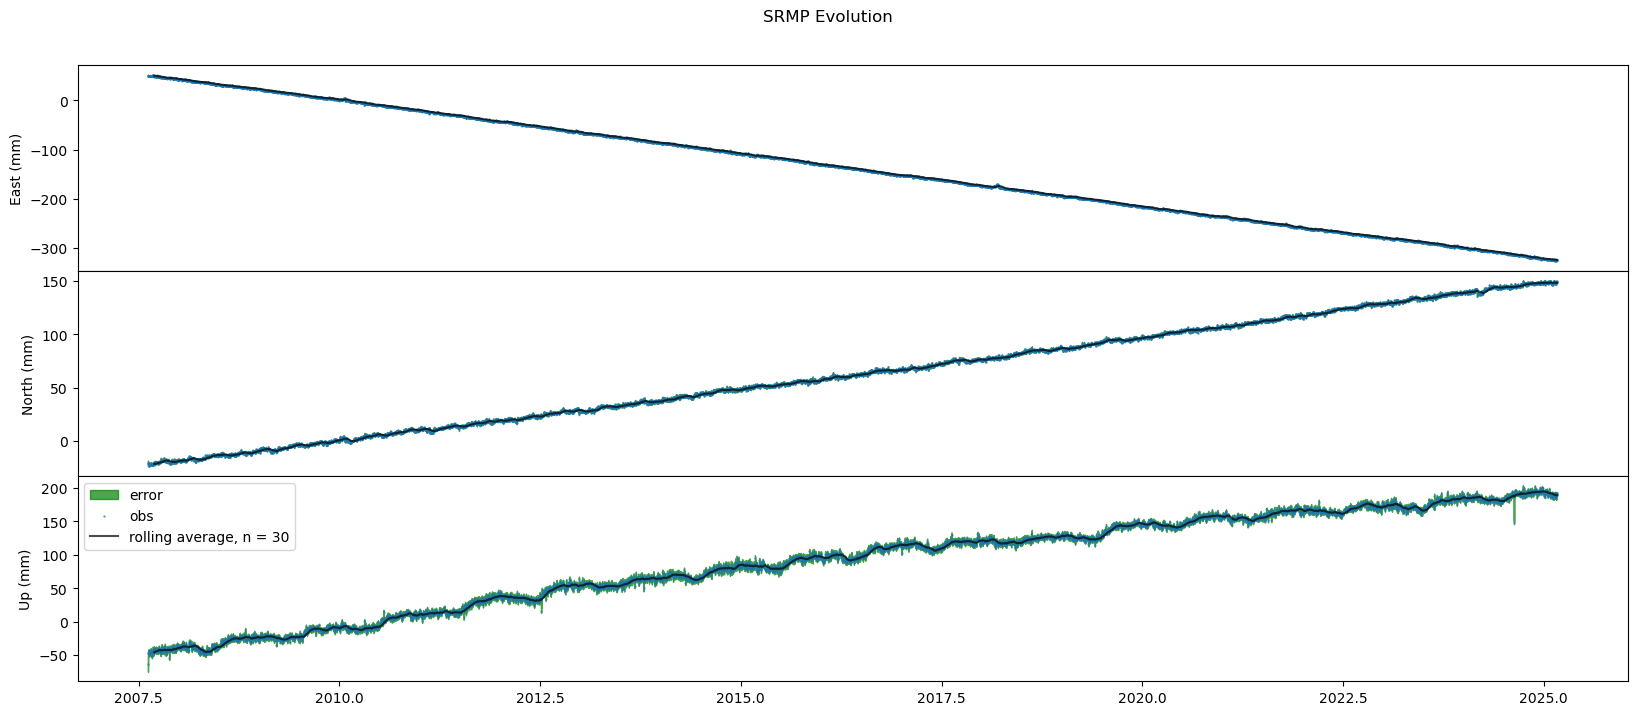

In [69]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(20,8))
fig.subplots_adjust(hspace=0)

axs[0].fill_between(AASI_time, AASI_data[:,0] + AASI_error[:,0], AASI_data[:,0] - AASI_error[:,0], color = 'g')
axs[0].plot(AASI_time, AASI_data[:,0], marker = '.', ls = '', ms = 1.5, alpha = 0.6)

axs[1].fill_between(AASI_time, AASI_data[:,1] + AASI_error[:,1], AASI_data[:,1] - AASI_error[:,1], color = 'g', label = 'error', alpha = 0.7)
axs[1].plot(AASI_time, AASI_data[:,1], marker = '.', ls = '', ms = 1.5, alpha = 0.6)

axs[2].fill_between(AASI_time, AASI_data[:,2] + AASI_error[:,2], AASI_data[:,2] - AASI_error[:,2], color = 'g', label = 'error', alpha = 0.7)
axs[2].plot(AASI_time, AASI_data[:,2], marker = '.', ls = '', ms = 1.5, alpha = 0.6, label = 'obs')

axs[0].plot(AASI_time[29:], moving_avg_east, marker = '', ls = '-',  alpha = 0.7, c = 'black')
axs[1].plot(AASI_time[29:], moving_avg_north, marker = '', ls = '-',  alpha = 0.7, c = 'black')
axs[2].plot(AASI_time[29:], moving_avg_up, marker = '', ls = '-',  alpha = 0.7, c = 'black', label = 'rolling average, n = 30')

axs[0].set_ylabel('East (mm)')
axs[0].set_xlabel('Date')
axs[1].set_ylabel('North (mm)')
axs[2].set_ylabel('Up (mm)')

axs[2].legend()
fig.suptitle('SRMP Evolution', y = 0.95)


lat/lon/elev (d/d/m):	72.9107	-54.3937	370.6

Through time, we can observe that the sensor is moving to the northwest while moving up. Crust is spreading out.

The detrended versions show 

## Detrended Climatology 
Changed dates from decimals to datetime and made into a pandas dataframe for easier manipulation.

In [70]:
import datetime

def decimal_year_to_date(decimal_year):
    """
    Converts a decimal year to a datetime.date object.
    """
    year = int(decimal_year)
    fractional_part = decimal_year - year

    # Determine if it's a leap year for accurate day calculation
    is_leap = (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0)
    days_in_year = 366 if is_leap else 365

    # Calculate the number of days from the start of the year
    days_offset = fractional_part * days_in_year

    # Create a datetime object for January 1st of that year
    start_of_year = datetime.date(year, 1, 1)

    # Add the calculated offset in days
    result_date = start_of_year + datetime.timedelta(days=days_offset)

    return result_date

# Example usage:
decimal_year_value = AASI_time[1261]
date_result = decimal_year_to_date(decimal_year_value)
print(f"The decimal year {decimal_year_value} converts to: {date_result}")

The decimal year 2011.066383 converts to: 2011-01-25


In [71]:
converted_dates = np.array([decimal_year_to_date(dy) for dy in AASI_time])

In [72]:
df = pd.DataFrame({'date':converted_dates})
df['east'] = pd.Series(AASI_data_detrended[:,0])
df['north'] = pd.Series(AASI_data_detrended[:,1])
df['up'] = pd.Series(AASI_data_detrended[:,2])

df.set_index('date', inplace=True)
df

climatology = df.groupby('date').mean('date').values 
climatology

array([[ -0.73210487,   2.61454439, -31.1522196 ],
       [ -0.77713007,   2.25366945, -15.41701994],
       [ -1.43115526,   2.88379452, -14.43082028],
       ...,
       [  0.85347352,   0.77082389, -18.26798596],
       [  1.17244832,   0.20494896, -20.0637863 ],
       [  1.45742313,   0.09607402, -18.54058664]])

In [73]:
df['month_day'] = df.index.map(lambda x: x.strftime('%m-%d'))

climatology = df.groupby('month_day')[['east', 'north', 'up']].mean()
climatology

df['month'] = df.index.map(lambda x: x.strftime('%m'))
climatology_monthly = df.groupby('month')[['east', 'north', 'up']].mean()
climatology_monthly

,east,north,up
month,,,
01,-0.065154,-0.243140,1.711101
02,0.040607,-0.532281,0.539971
03,0.170057,-0.848211,-0.809845
04,0.124365,-0.212433,-3.553259
05,0.145006,0.087111,-5.253676
06,0.304799,0.178035,-5.763809
07,0.155938,0.190097,-1.595845
08,0.024487,0.241442,2.302488
09,-0.079562,0.557337,3.488777


In [74]:
df['month'] = df.index.map(lambda x: x.strftime('%m'))
climatology_monthly = df.groupby('month')[['east', 'north', 'up']].mean()
climatology_monthly

,east,north,up
month,,,
01,-0.065154,-0.243140,1.711101
02,0.040607,-0.532281,0.539971
03,0.170057,-0.848211,-0.809845
04,0.124365,-0.212433,-3.553259
05,0.145006,0.087111,-5.253676
06,0.304799,0.178035,-5.763809
07,0.155938,0.190097,-1.595845
08,0.024487,0.241442,2.302488
09,-0.079562,0.557337,3.488777


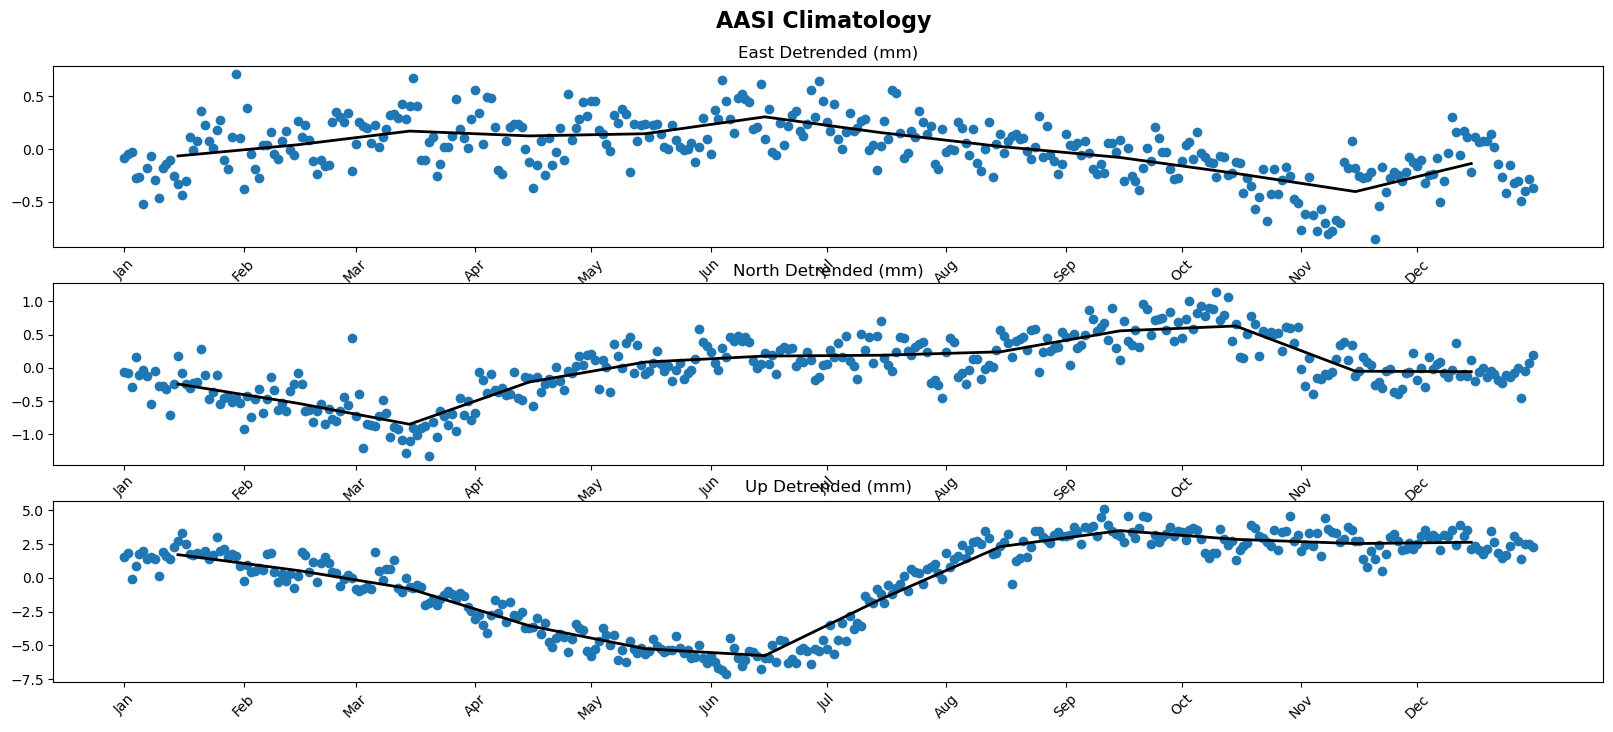

In [76]:
fig, axs = plt.subplots(3, 1, figsize=(20, 8))
Time_months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
month_ticks = [f'{month:02d}-01' for month in range(1, 13)]

axs[0].scatter(climatology.index,climatology['east'])
axs[1].scatter(climatology.index,climatology['north'])
axs[2].scatter(climatology.index,climatology['up'])

monthly_aligned_index = [f"{month}-15" for month in climatology_monthly.index]

axs[0].plot(monthly_aligned_index, climatology_monthly['east'], lw = 2, c = 'black')
axs[1].plot(monthly_aligned_index, climatology_monthly['north'], lw = 2, c = 'black')
axs[2].plot(monthly_aligned_index, climatology_monthly['up'], lw = 2, c = 'black')

for ax in axs:
    ax.set_xticks(month_ticks) 
    ax.set_xticklabels(Time_months, rotation=45)
    
axs[0].set_title('East Detrended (mm)', size = 12)
axs[1].set_title('North Detrended (mm)', size = 12)
axs[2].set_title('Up Detrended (mm)', size = 12)

fig.suptitle('AASI Climatology', weight= 'bold', size = 16, y = 0.95, x = 0.51)
plt.show()

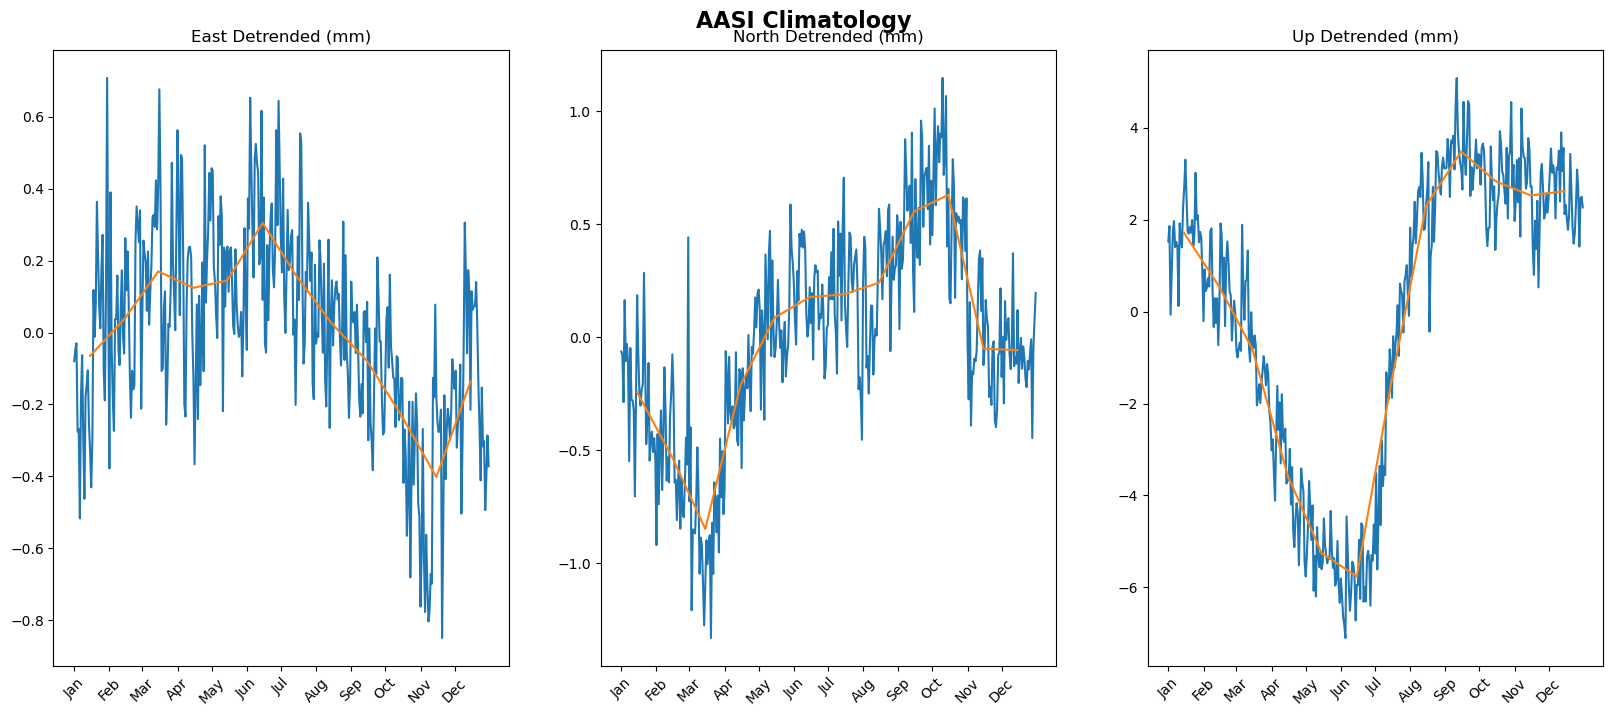

In [77]:
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
Time_months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
month_ticks = [f'{month:02d}-01' for month in range(1, 13)]

axs[0].plot(climatology['east'])
axs[1].plot(climatology['north'])
axs[2].plot(climatology['up'])

monthly_aligned_index = [f"{month}-15" for month in climatology_monthly.index]

axs[0].plot(monthly_aligned_index, climatology_monthly['east'])
axs[1].plot(monthly_aligned_index, climatology_monthly['north'])
axs[2].plot(monthly_aligned_index, climatology_monthly['up'])

for ax in axs:
    ax.set_xticks(month_ticks) 
    ax.set_xticklabels(Time_months, rotation=45)
    
axs[0].set_title('East Detrended (mm)', size = 12)
axs[1].set_title('North Detrended (mm)', size = 12)
axs[2].set_title('Up Detrended (mm)', size = 12)

fig.suptitle('AASI Climatology', weight= 'bold', size = 16, y = 0.93)
plt.show()

To think about:
- Maybe lets do a 3D Plot to see how the vectors are moving (or at least east and north)
- lets see if its possible to also obtain precipitation and temperature data.
- Up seems to behave like a cosine function.
- Lets calculate the reproducability index for each of them
- pca of day of year vs data. maybe svd too
- we do see that when there is melt (goes down), the sensor also moves to the northeast. Novemeber/December seems to have a small dip (which also appears on the north and east trend) --> check if this also happens on other datasets
- - rolling average?

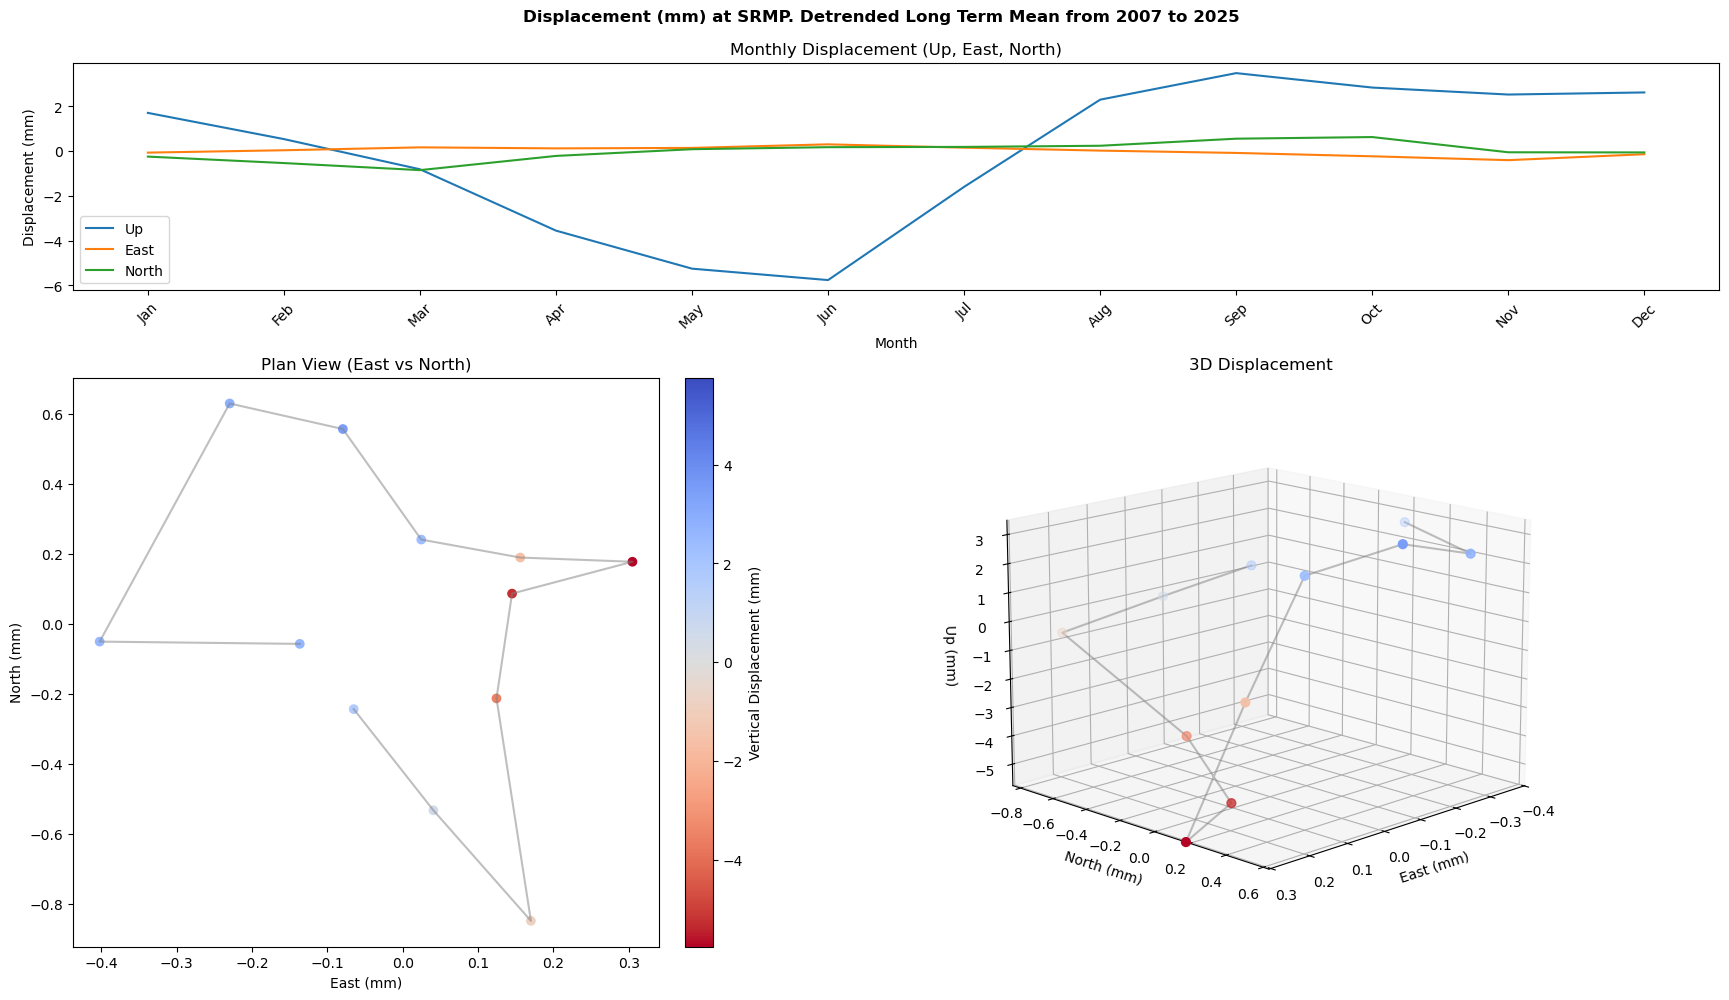

In [315]:
import matplotlib.animation as animation
import matplotlib 
import matplotlib.cm as cm


fig = plt.figure(figsize=(18, 10))
subfigs = fig.subfigures(2, 1, height_ratios=[0.8, 2], hspace=-.3)

Time_months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
month_ticks = [f'{month:02d}' for month in range(1, 13)]

ax_top = subfigs[0].subplots(1, 1,)
subfigs[0].subplots_adjust(top = 0.5,)
ax_top.plot(climatology_monthly['up'], label='Up')
ax_top.plot(climatology_monthly['east'], label='East')
ax_top.plot(climatology_monthly['north'], label='North')
ax_top.set_xlabel("Month")
ax_top.set_ylabel("Displacement (mm)")
ax_top.legend()
ax_top.set_title("Monthly Displacement (Up, East, North)")
ax_top.set_xticks(month_ticks) 
ax_top.set_xticklabels(Time_months, rotation=45)


axs_bottom = subfigs[1].subplots(1, 2, width_ratios=[0.7, 1],)

# Left subplot: 2D plot of North vs East
cmap = cm.coolwarm_r
norm = plt.Normalize(vmin=climatology_monthly['up'].min(), vmax=-1*climatology_monthly['up'].min())


axs_bottom[0].plot(climatology_monthly['east'], climatology_monthly['north'], color='gray', alpha=0.5)


sc = axs_bottom[0].scatter(
    climatology_monthly['east'],
    climatology_monthly['north'],
    c=climatology_monthly['up'],  # values to map to colors
    cmap=cmap,
    norm=norm
)

axs_bottom[0].set_xlabel("East (mm)")
axs_bottom[0].set_ylabel("North (mm)")
axs_bottom[0].set_title("Plan View (East vs North)")

cbar = plt.colorbar(sc, ax=axs_bottom[0], fraction=0.046, pad=0.04)
cbar.set_label("Vertical Displacement (mm)")

# Right subplot: 3D animated plot
ax3d = subfigs[1].add_subplot(1, 2, 2, projection='3d')
subfigs[1].subplots_adjust(hspace = -3)
ax3d.view_init(elev=15, azim=45)
ax3d.set_xlabel("East (mm)")
ax3d.set_ylabel("North (mm)")
ax3d.set_zlabel("Up (mm)")
ax3d.set_xlim(climatology_monthly['east'].min(), climatology_monthly['east'].max())
ax3d.set_ylim(climatology_monthly['north'].min(), climatology_monthly['north'].max())
ax3d.set_zlim(climatology_monthly['up'].min(), climatology_monthly['up'].max())
ax3d.set_title("3D Displacement")

# Initialize line for animation

line3d, = ax3d.plot([], [], [], color='gray', alpha=0.5)  # create line once
xs = climatology_monthly['east']
ys = climatology_monthly['north']
zs = climatology_monthly['up']
cs = climatology_monthly['up']

sc3d = ax3d.scatter(xs, ys, zs, c=cs, cmap=cmap, norm=norm, s=40)

def update(num):
    xs = climatology_monthly['east'][:num]
    ys = climatology_monthly['north'][:num]
    zs = climatology_monthly['up'][:num]
    cs = climatology_monthly['up'][:num]  
    
    # Update line data
    line3d.set_data(xs, ys)
    line3d.set_3d_properties(zs)

    # Update scatter offsets and colors without recreating the artist
    sc3d._offsets3d = (xs, ys, zs)
    sc3d.set_array(cs)  # update colors to subset but keep colormap fixed

    return line3d, sc3d



# Create animation
fig.tight_layout()
plt.delaxes(axs_bottom[1])

anim = animation.FuncAnimation(
    fig, update, frames=len(climatology_monthly), interval=500, blit=False)

# Title and save
fig.suptitle("Displacement (mm) at SRMP. Detrended Long Term Mean from 2007 to 2025", y=0.95, x=0.52, weight = 'bold')


anim.save('ClimatologySRMPDetrended.gif', writer='pillow')
plt.show()

In [253]:
StationData = df = pd.read_csv('/Users/dlugardo/Documents/GitHub/signal-processing-enu/GreenlandStations.csv')
StationData

,station,latitude,longitude,elevation_m,is_greenland
0,NGFJ,80.568475,-16.841131,35.5,True
1,JWLF,83.111656,-45.119847,112.9,True
2,THU4,76.537106,-68.824953,36.2,True
3,JGBL,82.208758,-31.004208,753.3,True
4,THU2,76.537047,-68.825050,36.2,True
...,...,...,...,...,...
72,MIK2,68.140281,-31.451825,815.9,True
73,KUAQ,68.587000,-33.052750,865.2,True
74,KSUT,64.070697,-52.007697,40.7,True
75,RINK,71.848500,-50.993967,1337.9,True


In [310]:
StationData.loc[StationData['station']=='SRMP']

,station,latitude,longitude,elevation_m,is_greenland
60,SRMP,72.910678,-54.393711,370.6,True


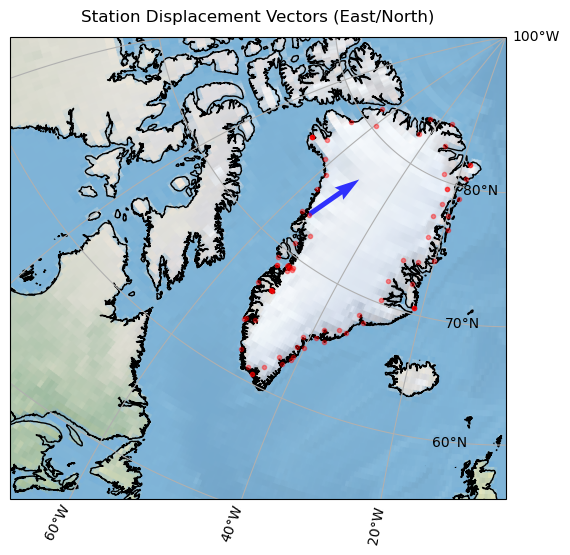

In [316]:
import cartopy.crs as crs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

import cartopy.crs as ccrs

fig= plt.figure(figsize=(8,6))
# Create a GeoAxes in the tile's projection.
ax = plt.axes(projection=ccrs.Stereographic())

# Limit the extent of the map to a small longitude/latitude range.
ax.set_extent([-80, -5, 55, 90])
ax.gridlines(draw_labels=True)
ax.stock_img()
ax.coastlines(resolution='10m')

# Add a marker for stations.
for i in range(len(StationData)):
    plt.plot(StationData.longitude[i], StationData.latitude[i], marker='o', color='red', markersize=3,
            alpha=0.4, transform=ccrs.Geodetic(), label = StationData.station[i] )

# === ADD VECTOR DISPLACEMENTS ===

# Example: use average displacement over the year, or for a specific month
# Here, assuming one displacement vector per station
# And assuming StationData and climatology_monthly align row-wise
# Replace these with actual logic if needed
month_idx = 6  # July (0-based)

# Extract displacement arrays per station for July
U = np.array([climatology_monthly['east'].iloc[month_idx]])
V = np.array([climatology_monthly['north'].iloc[month_idx]])

Lons = StationData.loc[StationData['station']=='SRMP']['longitude'].values
Lats = StationData.loc[StationData['station']=='SRMP']['latitude'].values

# Optional: scale arrows for visibility
scale_factor = 10e6  # Change this as needed

# Plot displacement vectors (in mm, scaled)
ax.quiver(
    Lons, Lats,
    U * scale_factor, V* scale_factor,
    angles='xy',
    scale_units='xy',
    scale=3,
    color='blue',
    transform=ccrs.PlateCarree(),
    width=.01,
    alpha=0.8
)

plt.title("Station Displacement Vectors (East/North)")
plt.show()

Text(0.5, 1.0, 'Stations')

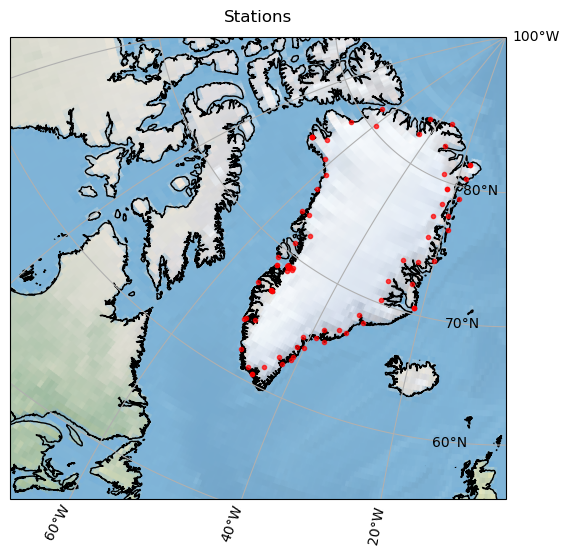

In [302]:
import cartopy.crs as crs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

import cartopy.crs as ccrs

fig= plt.figure(figsize=(8,6))
# Create a GeoAxes in the tile's projection.
ax = plt.axes(projection=ccrs.Stereographic())

# Limit the extent of the map to a small longitude/latitude range.
ax.set_extent([-80, -5, 55, 90])
ax.gridlines(draw_labels=True)
ax.stock_img()
ax.coastlines(resolution='10m')

# Add a marker for stations.

for i in range(len(StationData)):
    plt.plot(StationData.longitude[i], StationData.latitude[i], marker='o', color='red', markersize=3,
            alpha=0.7, transform=ccrs.Geodetic(), label = StationData.station[i] )

plt.title('Stations')

In [267]:
import pandas as pd
import numpy as np
import scipy.signal

all_stations_data = []

for station in StationData.station:
    try:        
        raw_data = get_data(station) 

        time = raw_data[:, 0]
        converted_dates = np.array([decimal_year_to_date(dy) for dy in time])
        data = raw_data[:, 1:4]
        error = raw_data[:, 4:]

        data_detrended = scipy.signal.detrend(data, axis=0)

        # Create a DataFrame for this station
        df = pd.DataFrame({
            'station': station,
            'decimal_time': time,
            'dates': converted_dates,
            'data_x_raw': data_detrended[:, 0],
            'data_y_raw': data_detrended[:, 1],
            'data_z_raw': data_detrended[:, 2],
            'data_x_det': data[:, 0],
            'data_y_det': data[:, 1],
            'data_z_det': data[:, 2],
            'error_x': error[:, 0],
            'error_y': error[:, 1],
            'error_z': error[:, 2],
        })

        all_stations_data.append(df)

    except FileNotFoundError as e:
        print(f"  → File not found for station {station}. Skipping.")
        continue
    
    except Exception as e:
        print(f"  → Error processing station {station}: {e}")
        continue

Observations = pd.concat(all_stations_data, ignore_index=True)
Observations
    

  → File not found for station THU4. Skipping.
  → File not found for station QENU. Skipping.
  → File not found for station AAS2. Skipping.
  → File not found for station SCO4. Skipping.
  → File not found for station STNO. Skipping.
  → File not found for station QAQ2. Skipping.
  → File not found for station KLQ3. Skipping.
  → File not found for station THU3. Skipping.
  → File not found for station KSUT. Skipping.


,station,decimal_time,dates,data_x_raw,data_y_raw,data_z_raw,data_x_det,data_y_det,data_z_det,error_x,error_y,error_z
0,NGFJ,2024.616007,2024-08-13,-1.008374,-0.273050,-9.230060,-201.120,297.698,115.919,0.556,0.630,3.366
1,NGFJ,2024.618745,2024-08-14,-1.095676,-0.431153,-2.607764,-201.244,297.596,122.509,0.535,0.607,3.232
2,NGFJ,2024.621483,2024-08-15,-2.772978,0.033743,6.615533,-202.958,298.117,131.700,0.549,0.629,3.391
3,NGFJ,2024.624220,2024-08-16,-1.440280,-0.428361,-3.116171,-201.662,297.711,121.936,0.556,0.625,3.343
4,NGFJ,2024.626958,2024-08-17,-2.062582,0.171536,5.945126,-202.321,298.367,130.965,0.551,0.631,3.391
...,...,...,...,...,...,...,...,...,...,...,...,...
352703,NRSK,2025.155364,2025-02-26,7.792091,-6.845643,-20.126151,-136.145,314.346,72.113,0.652,0.750,3.918
352704,NRSK,2025.158101,2025-02-27,5.519950,-7.561616,-6.607280,-138.444,313.690,85.649,0.676,0.809,4.151
352705,NRSK,2025.160839,2025-02-28,3.743809,-1.777590,5.902590,-140.247,319.534,98.176,0.686,0.842,4.227
352706,NRSK,2025.163577,2025-03-01,2.958667,-1.289563,1.947460,-141.059,320.082,94.238,0.682,0.810,4.157


## Detrended and Deseasonalized Data
Substract climatology to detrended data.

## Fourier Transformation
Breaks down the signal into harmonic functions. (variability, seasonality)

## Vector Autoregression 
Used on Detrended Data. 

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

In [19]:
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        
def plot_series(data):
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 8))
    for i, col in enumerate(data.columns):
        data[col].plot(ax=axes[i], title=col)
        axes[i].set_ylabel('Values')
        axes[i].set_xlabel('Date')
    plt.tight_layout()
    plt.show()

In [20]:
DataDetrended = pd.DataFrame({'date':converted_dates})
DataDetrended['east'] = pd.Series(AASI_data_detrended[:,0])
DataDetrended['north'] = pd.Series(AASI_data_detrended[:,1])
DataDetrended['up'] = pd.Series(AASI_data_detrended[:,2])
DataDetrended.set_index('date', inplace=True)
DataDetrended


,east,north,up
date,,,
2007-08-13,-0.732105,2.614544,-31.152220
2007-08-14,-0.777130,2.253669,-15.417020
2007-08-15,-1.431155,2.883795,-14.430820
2007-08-16,-2.116180,3.001920,-15.081621
2007-08-17,-1.568206,1.482045,-12.061421
...,...,...,...
2025-02-26,1.205524,-0.289426,-25.590385
2025-02-27,0.012499,0.832699,-22.506186
2025-02-28,0.853474,0.770824,-18.267986


In [21]:
DataDetrendedTraining = DataDetrended.iloc[:6349, :]
DataDetrendedTraining

,east,north,up
date,,,
2007-08-13,-0.732105,2.614544,-31.152220
2007-08-14,-0.777130,2.253669,-15.417020
2007-08-15,-1.431155,2.883795,-14.430820
2007-08-16,-2.116180,3.001920,-15.081621
2007-08-17,-1.568206,1.482045,-12.061421
...,...,...,...
2024-12-27,2.083061,1.859945,-11.390565
2024-12-28,1.746036,-0.241930,-15.417365
2024-12-29,1.700010,-0.341805,-13.103165


Step 1: Checking stationarity
Stationarity test for east
ADF Statistic: -5.57422292399214
p-value: 1.4443620755115933e-06
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationarity test for north
ADF Statistic: -6.191572828935747
p-value: 6.104770527788055e-08
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationarity test for up
ADF Statistic: -2.381721258131014
p-value: 0.14696204592596862
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567

Step 2: Applying VAR model

Step 3: Forecasting

Step 4: Visualizing forecast


/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


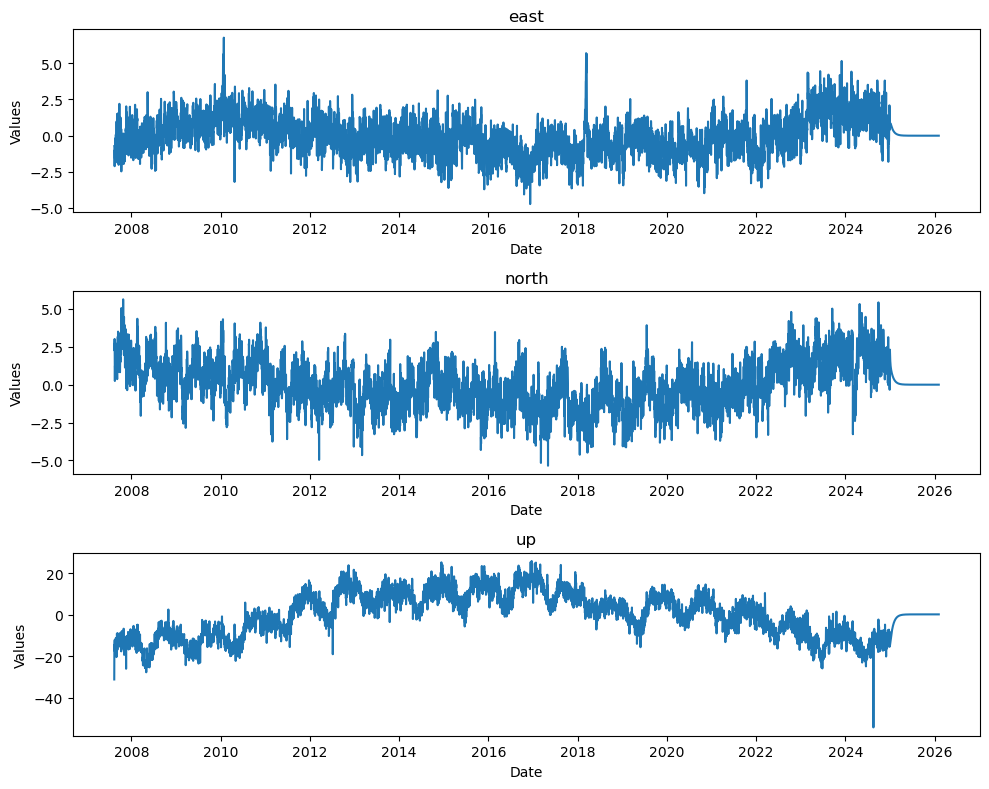

In [22]:
# Section for VAR analysis
def var_analysis(data):
    # Step 1: Check stationarity and visualize the original data
    print("Step 1: Checking stationarity")
    for col in data.columns:
        print('Stationarity test for', col)
        check_stationarity(data[col])

    # Step 2: Applying VAR model
    print("\nStep 2: Applying VAR model")
    model = VAR(data)
    results = model.fit()

    # Step 3: Forecasting
    print("\nStep 3: Forecasting")
    lag_order = results.k_ar
    forecast = results.forecast(data.values[-lag_order:], steps=400)

    # Step 4: Visualizing forecast
    print("\nStep 4: Visualizing forecast")
    forecast_index = pd.date_range(start='2025-01-01', periods=400)
    forecast_data = pd.DataFrame(forecast, index=forecast_index, columns=data.columns)
    plot_series(pd.concat([data, forecast_data]))

# Perform VAR analysis
var_analysis(DataDetrendedTraining)

Didn't work out. Learn why

## Spectral Analysis
By doing so, we can break into smaller parts the signals, allowing us to isolate seasonality from variability

In [23]:
df

,east,north,up,month_day,month
date,,,,,
2007-08-13,-0.732105,2.614544,-31.152220,08-13,08
2007-08-14,-0.777130,2.253669,-15.417020,08-14,08
2007-08-15,-1.431155,2.883795,-14.430820,08-15,08
2007-08-16,-2.116180,3.001920,-15.081621,08-16,08
2007-08-17,-1.568206,1.482045,-12.061421,08-17,08
...,...,...,...,...,...
2025-02-26,1.205524,-0.289426,-25.590385,02-26,02
2025-02-27,0.012499,0.832699,-22.506186,02-27,02
2025-02-28,0.853474,0.770824,-18.267986,02-28,02


In [24]:
from scipy.fft import dct, idct

Breathing Map (Resultant Vectors\)